# Slide Graph Pipeline

<a href="https://colab.research.google.com/github/TIA-Lab/tiatoolbox/blob/master/examples/07_example_mutationprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://kaggle.com/kernels/welcome?src=https://github.com/TIA-Lab/tiatoolbox/blob/master/examples/06_example_mutationprediction.ipynb" target="_blank"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open In Kaggle"/></a>

_In order to run this notebook on a Kaggle platform, 1) click on the blue Kaggle badge saying Open in Kaggle 2) click on Settings on the right of the Kaggle screen, 3) log in to your Kaggle account, 4) tick "Internet" checkbox under Settings, to enable necessary downloads._

## About this notebook
This jupyter notebook can be run on any computer with a standard browser and no prior installation of any programming language is required. It can run remotely over the Internet, free of charge, thanks to Google Colaboratory or Kaggle. To connect with Colab or Kaggle, click on one of the two blue checkboxes above. Check that "colab" or "kaggle", as appropriate, appears in the address bar. You can right-click on "Open in Colab" and select "Open in new tab" if the left click does not work for you. Familiarize yourself with the drop-down menus near the top of the window. You can edit the notebook during the session, for example substituting your own image files for the image files used in this demo. Experiment by changing the parameters of functions. It is not possible for an ordinary user to permanently change this version of the notebook on Github, Colab or Kaggle, so you cannot inadvertently mess it up. Use the notebook's File Menu if you wish to save your own (changed) notebook.

To run the notebook on any platform, except for Colab or Kaggle, set up your Python environment, as explained in the 
[README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package) file.


# Introduction

This notebook is aimed at advanced users who are interersted in using
TIAToolbox as part of an experiment or larger project. Here we replicate
the method in "SlideGraph+: Whole Slide Image Level Graphs
to Predict HER2Status in Breast Cancer" by Liu et al. (2020) to generate
a graph and predict a slide level label. Our task
is to classify if a whole slide image (WSI) is
[HER2](https://en.wikipedia.org/wiki/HER2/neu) negative or positive.
To do this, we will use the
[TCGA-BRCA](https://portal.gdc.cancer.gov/projects/TCGA-BRCA) dataset.

Throughout this notebook we use modules from TIAToolbox to assist with
common tasks including:
- Patch extraction
- Stain normalization
- Cell segmentation & classification
- Extraction of deep features

You can skip the following cell if 1) you are not using the Colab or Kaggle plaforms or 2) you are using Colab or Kaggle and this is not your first run of the notebook in the current session. If you nevertheless run the cell, you may get an error message, but no harm will be done. On Colab or Kaggle the cell installs `tiatoolbox`, and other prerequisite software. Harmless error messages should be ignored. Outside Colab or Kaggle, the notebook expects `tiatoolbox` to already be installed. (See the instructions in [README](https://github.com/TIA-Lab/tiatoolbox/blob/master/README.md#install-python-package).)

In [ ]:
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools | tail --line 1
!pip uninstall tiatoolbox
!pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@example-slide-graph-pipeline | tail --line 1 

**[optional]**: if you are running this example notebook on your system and it is equipped with a Cuda enabled GPU, you can run the following cell to install Cuda enabled version of the torch package to utilize GPU computation and speed up the TIAToolbox models.

In [ ]:
#pip install torch==1.9.1+cu102 torchvision==0.10.1+cu102 -f https://download.pytorch.org/whl/cu102/torch_stable.html --user
ON_GPU = True
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu102.html

# Preperation: Imports, Helpers, & Data Split

We begin by importing common necessary libraries, defining some helper functions
and defining how we will split the dataset into train, validation, and test sets.

 ## Import Libraries

In [1]:
# Python standard library imports
from collections import OrderedDict
import copy
import os
import pathlib
import random
import shutil
import sys
from typing import Callable, List, Tuple
import warnings

# Third party imports
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL.Image import new
import torch
from tqdm import tqdm
# Use ujson as replacement for default json because it's faster for large JSON
import ujson as json

warnings.filterwarnings("ignore")

# ! save_yaml, save_as_json => need same name, need to factor out jsonify
from tiatoolbox.utils.misc import imread, save_as_json

mpl.rcParams['figure.dpi'] = 160  # for high resolution figure in notebook

## Helper Functions

Here we define some helper functions that will be used throughout the notebook:

In [4]:
def load_json(path: str):
    """Load JSON from a file path."""
    with open(path, "r") as fptr:
        json_dict = json.load(fptr)
    return json_dict


def rmdir(dir_path: str):
    """Remove a directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    return


def rm_n_mkdir(dir_path: str):
    """Remove then re-create a directory."""
    if os.path.isdir(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)
    return


def recur_find_ext(root_dir: str, exts: List[str]) -> List[str]:
    """Recursively find files with an extension in `exts`.

    This is much faster than glob if the folder
    hierachy is complicated and contain > 1000 files.

    Args:
        root_dir (str):
            Root directory for searching.
        exts (list):
            List of extensions to match.

    Returns:
        List of full paths with matched extension in sorted order.

    """
    assert isinstance(exts, list)
    file_path_list = []
    for cur_path, dir_list, file_list in os.walk(root_dir):
        for file_name in file_list:
            file_ext = pathlib.Path(file_name).suffix
            if file_ext in exts:
                full_path = os.path.join(cur_path, file_name)
                file_path_list.append(full_path)
    file_path_list.sort()
    return file_path_list

 ## Loading The Dataset

For this dataset (TCGA-BRCA), the HER2 status is provided per patient
 instead of per slide. Therefor, we assign the same label to all WSIs coming from the same patient. Additionally, WSIs that do not have labels are excluded from subsequent processing.

 We begin this notebook with loading the data by doing the following:
 1. Load a list of WSIs and associated tissue masks (file paths).
 2. Convert the clinical infomation in `.csv` to labels.
 3. Assign the patient label to each WSI
 4. Filter out WSIs which do not have a label.

 We use the following global variables:
 - `CLINICAL_FILE`: The `.csv` file which contains the patient code and
   the associated labels.
 - `ROOT_OUTPUT_DIR`: Root directory to save output under.
 - `WSI_DIR`: Directory contains WSIs.
 - `MSK_DIR`: Directory containing the corresponding WSI mask. If set to `None`,
   the subsequent process will use the default method in the toolbox to obtain
   the mask (via `WSIReader.tissue_mask`). Each mask file is assumed to be `.png`
   and any non-zero pixels within it are considered for the processing.

 By the end of this process, we obtain following variables for subsequent
 operations
 - `wsi_paths`: A list of file paths to WSIs.
 - `wsi_names`: A list of WSI names in `wsi_paths`.
 - `msk_paths`: A list of paths pointing to masks of each
   WSI in `wsi_paths`.
 - `label_df`: A panda dataframe containing two columns: `WSI-CODE` and "LABEL". Each row in the dataframe is a pair, whose    first entry is the name of a WSI in the list `wsi_names` and whose second entry is the label of that WSI.

In [ ]:
SEED = 5
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
# Set these variables to run next cell either
# seperately or with customized parameters
ROOT_OUTPUT_DIR = 'PATH'
WSI_DIR = 'PATH'
MSK_DIR = None
CLINICAL_FILE = 'PATH'

In [3]:
# * Query for paths

wsi_paths = recur_find_ext(WSI_DIR, [".svs", ".ndpi"])
wsi_names = [pathlib.Path(v).stem for v in wsi_paths]
msk_paths = None if MSK_DIR is None else [f"{MSK_DIR}/{v}.png" for v in wsi_names]
assert len(wsi_paths) > 0, "No files found."

# * Generate WSI labels
clinical_df = pd.read_csv(CLINICAL_FILE)
patient_uids = clinical_df["PATIENT"].to_numpy()
patient_labels = clinical_df["HER2FinalStatus"].to_numpy()

patient_labels_ = np.full_like(patient_labels, -1)
patient_labels_[patient_labels == "Positive"] = 1
patient_labels_[patient_labels == "Negative"] = 0
sel = patient_labels_ >= 0

patient_uids = patient_uids[sel]
patient_labels = patient_labels_[sel]
assert len(patient_uids) == len(patient_labels)
clinical_info = OrderedDict(list(zip(patient_uids, patient_labels)))

# Retrieve patient code of each WSI, this is based on TCGA barcodes:
# https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/
wsi_patient_codes = np.array(["-".join(v.split("-")[:3]) for v in wsi_names])
wsi_labels = np.array(
    [clinical_info[v] if v in clinical_info else np.nan for v in wsi_patient_codes]
)

# * Filter the WSIs and paths that do not have labels
sel = ~np.isnan(wsi_labels)
# Simple sanity checks before filtering
assert len(wsi_paths) == len(wsi_names)
assert len(wsi_paths) == len(wsi_labels)
wsi_paths = np.array(wsi_paths)[sel]
wsi_names = np.array(wsi_names)[sel]
wsi_labels = np.array(wsi_labels)[sel]

label_df = list(zip(wsi_names, wsi_labels))
label_df = pd.DataFrame(label_df, columns=["WSI-CODE", "LABEL"])

## Generate the Data Split

Now, we split our dataaset into disjoint train, validation, and test subsets.

To that end, we define a new function called `stratified_split`.
It receives:

- paired input of the samples and their labels
- the train, valid, and test percentages

and then returns a number of stratified splits.

**Stratification** means that, for each label, the proportion of samples with that label is as similar as possible in each of the three split. Stratification ensures that any bias that might result from a particular label operates as equally as possible in each split. This is a standard way of avoiding bias due to possible confounding factors – here each label is regarded as a possible confounding factor.

In [4]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit


def stratified_split(
        x: List,
        y: List,
        train: float,
        valid: float,
        test: float,
        num_folds: int,
        seed: int = 5):
    """Helper to generate stratified splits.

    Split `x` and `y` in to N number of `num_folds` sets
    of `train`, `valid`, and `test` set in stratified manner.
    `train`, `valid`, and `test` are guaranteed to be mutually
    exclusive.

    Args:
        x (list, np.ndarray): List of samples.
        y (list, np.ndarray): List of labels, each value is the value
            of the sample at the same index in `x`.
        train (float): Percentage to be used for training set.
        valid (float): Percentage to be used for validation set.
        test (float): Percentage to be used for testing set.
        num_folds (int): Number of split generated.
    Returns:
        A list of splits where each is a dictionary of
        {
            'train': [(sample_A, label_A), (sample_B, label_B), ...],
            'valid': [(sample_C, label_C), (sample_D, label_D), ...],
            'test' : [(sample_E, label_E), (sample_E, label_E), ...],
        }

    """
    assert train + valid + test - 1.0 < 1.0e-10, "Ratio must be summed up to 1.0 ."

    outer_splitter = StratifiedShuffleSplit(
        n_splits=num_folds,
        train_size=train + valid,
        random_state=seed
    )
    inner_splitter = StratifiedShuffleSplit(
        n_splits=1,
        train_size=train / (train + valid),
        random_state=seed,
    )

    x = np.array(x)
    y = np.array(y)
    splits = []
    for train_valid_idx, test_idx in outer_splitter.split(x, y):
        test_x = x[test_idx]
        test_y = y[test_idx]

        # Holder for train_valid set
        x_ = x[train_valid_idx]
        y_ = y[train_valid_idx]

        # Split train_valid into train and valid set
        train_idx, valid_idx = list(inner_splitter.split(x_, y_))[0]
        valid_x = x_[valid_idx]
        valid_y = y_[valid_idx]

        train_x = x_[train_idx]
        train_y = y_[train_idx]

        # Integrity check
        assert len(set(train_x).intersection(set(valid_x))) == 0
        assert len(set(valid_x).intersection(set(test_x))) == 0
        assert len(set(train_x).intersection(set(test_x))) == 0

        splits.append(
            {
                "train": list(zip(train_x, train_y)),
                "valid": list(zip(valid_x, valid_y)),
                "test": list(zip(test_x, test_y)),
            }
        )
    return splits

 Now, we split the data with given ratio.


In [5]:
CACHE_PATH = None
SPLIT_PATH = f'{ROOT_OUTPUT_DIR}/splits.dat'

NUM_FOLDS = 5
TEST_RATIO = 0.2
TRAIN_RATIO = 0.8 * 0.9
VALID_RATIO = 0.8 * 0.1

if CACHE_PATH and os.path.exists(CACHE_PATH):
    splits = joblib.load(CACHE_PATH)
    SPLIT_PATH = CACHE_PATH
else:
    x = np.array(label_df["WSI-CODE"].to_list())
    y = np.array(label_df["LABEL"].to_list())
    splits = stratified_split(
        x, y,
        TRAIN_RATIO, VALID_RATIO, TEST_RATIO,
        NUM_FOLDS)

    joblib.dump(splits, SPLIT_PATH)

# Generating Graphs from WSIs
 
Now that we have definef our sources of data, we move on to transforming
them into a more usable form. We represent each WSI as a graph. Each node
in the graph corresponds to one patch within the WSI and is then
represented by a set of features. Here, we show using two different
feature representations:

- Deep Neural Network features: obtained from the global average
  pooling layer after we apply ResNet50 on the patch.
- Cellular composition: where we count the number of nuclei of each type within
  the patch.

With these node-level representations (or features), we then perform clustering
so that nodes that are close to each other both in feature space and in the 2D
space (i.e the WSI canvas) are assigned to the same cluster. These clusters are
then linked to other clusters within a certain distance, thus making up a WSI graph.

**Note**: Features of patches and theirs positions within each WSI
will be stored separately in files named `*.features.npy` and `*.position.npy` .
The `position` of a feature is, by definition, the patch bounding box
`(start_x, start_y, end_x, end_y)` at the highest resolution.
Subsequent function definitions will be based upon this convention.

## Deep Feature Extraction

We now show how to use the toolbox to extract features. We package
it into a small function called `extract_deep_features` for better organization.

In this function, we define the config object which defines the shape and magnification of the
patch we want to extract. Although the patches are allowed to have arbitrary size and differing
resolutions, here we use a patch of size 512x512 with 0.25 microns-per-pixel (`mpp=0.25`).
We use ResNet50 trained on ImageNet as a feature extractor. For more
detail on how to further customize this, you can refer to [this notebook](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/07_example_modeltechniques.ipynb).

We explain how to construct a customized preprocessing function that we would like
the `engine` to perform on each input patch. For this notebook, we perform stain-normalization
on each image patch. We show how this function can be defined later. (`engine`
is a set of classes defined under `tiatoolbox.models.engine`. Each instance of these classes has
multiple properties and abilities, possibly incorporating several functions.)

By default, the names of output files from the toolbox are
changed to sequentially ordered names (000.*.npy, 001.*.npy, etc.) to avoid
inadvertent overwriting. A mapping from output path name to input path name is returned by the engine,
making the name change easy to manage.

In this demo, we use a toolbox model with only one head (output channel).
For each input, we will have `*.position.npy` and `*.features.0.npy`.
In the case of models having multiple output heads (output channels), the output is
`['*.position.npy', '*.features.0.npy', '*.features.1.npy', etc.]` . The positions are always
defined as the patch bounding box `(start_x, start_y, end_x, end_y)` at the highest resolution
within the list of input resolutions. Refer to the [semantic segmentation notebook](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/06_example_semanticsegmentation.ipynb)
for details.

> **Note**: If you do not want to construct the graphs and only want to try out the graph neural
> network portion, we provide pre-generated graphs based on cell-composition features extracted from
> HoVer-Net in at this [link](https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition/graphs.zip).
> After downloading and extracting them, please follow subsequent instructions.

In [6]:
from tiatoolbox.models import FeatureExtractor, IOSegmentorConfig
from tiatoolbox.models.architecture import CNNExtractor


def extract_deep_features(
        wsi_paths: List[str],
        msk_paths: List[str],
        save_dir: str,
        preproc_func: Callable = None):
    ioconfig = IOSegmentorConfig(
        input_resolutions=[
            {"units": "mpp", "resolution": 0.25},
        ],
        output_resolutions=[
            {"units": "mpp", "resolution": 0.25},
        ],
        patch_input_shape=[512, 512],
        patch_output_shape=[512, 512],
        stride_shape=[512, 512],
        save_resolution={"units": "mpp", "resolution": 8.0},
    )
    model = CNNExtractor("resnet50")
    extractor = FeatureExtractor(
        batch_size=16, model=model, num_loader_workers=4)
    # Injecting customized preprocessing functions,
    # check the document or sample code below for API.
    extractor.model.preproc_func = preproc_func

    rmdir(save_dir)
    output_map_list = extractor.predict(
        wsi_paths,
        msk_paths,
        mode="wsi",
        ioconfig=ioconfig,
        on_gpu=True,
        crash_on_exception=True,
        save_dir=save_dir,
    )

    # Rename output files
    for input_path, output_path in output_map_list:
        input_name = pathlib.Path(input_path).stem

        output_parent_dir = pathlib.Path(output_path).parent

        src_path = pathlib.Path(f'{output_path}.position.npy')
        new_path = pathlib.Path(f'{output_parent_dir}/{input_name}.position.npy')
        src_path.rename(new_path)

        src_path = pathlib.Path(f'{output_path}.features.0.npy')
        new_path = pathlib.Path(f'{output_parent_dir}/{input_name}.features.npy')
        src_path.rename(new_path)

    return output_map_list

## Cell Composition Extraction

In a similar manner, we define the code to extract cell
composition in `extract_composition_features`. First, we need to
detect all nuclei in the WSI and their types. This can be
easily achieved via the `tiatoolbox.models.NucleusInstanceSegmentor`
engine and the HoVer-Net pretrained model, both provided in the toolbox.
Once we have the nuclei, we split the WSI into patches
and count the nuclei of each type in each patch.
We encapsulate this process in the function `get_composition_features`.

Unlike the `FeatureExtractor` above, engine from `NucleusInstanceSegmentor`
returns a single output file given a single WSI input. Their corresponding
output files are named as `['*/0.dat', '*/1.dat', etc.]` and we will also
need to rename them accordingly. We further generate the cell composition
features from each of these files and saved under `*.features.npy` and
`*.position.npy` respectively.

In [7]:
import pygeos  # replace with annotation store later
from tiatoolbox.wsicore.wsireader import get_wsireader
from tiatoolbox.models import NucleusInstanceSegmentor
from tiatoolbox.tools.patchextraction import PatchExtractor


def get_cell_compositions(
            wsi_path: str,
            inst_pred_path: str,
            save_dir: str,
            num_types: int = 6,
            patch_input_shape: Tuple[int] = (512, 512),
            stride_shape: Tuple[int] = (512, 512),
            resolution: float = 0.25,
            units: str = 'mpp',
        ):
    """
    Args:
        out_path (str): Path pointing to file containing nucleus
            instance predictions, assumed to be from tiatoolbox.

    """

    reader = get_wsireader(wsi_path)
    inst_pred = joblib.load(inst_pred_path)
    # Convert to {key: int, value: dict}
    inst_pred = {
        i: v for i, (_, v) in enumerate(inst_pred.items())
    }

    inst_boxes = [v['box'] for v in inst_pred.values()]
    inst_boxes = np.array(inst_boxes)
    # Replace with annotation store later
    spatial_indexer = pygeos.STRtree(
        pygeos.box(
            inst_boxes[:, 0],
            inst_boxes[:, 1],
            inst_boxes[:, 2],
            inst_boxes[:, 3],
        )
    )

    # * Generate patch coordinates (in xy format)
    wsi_shape = reader.slide_dimensions(resolution=resolution, units=units)

    (patch_inputs, _) = PatchExtractor.get_coordinates(
        image_shape=wsi_shape,
        patch_input_shape=patch_input_shape,
        patch_output_shape=patch_input_shape,
        stride_shape=stride_shape,
    )

    bounds_compositions = []
    for bounds in patch_inputs:
        indices = spatial_indexer.query(
                    pygeos.box(*bounds), predicate='contains')
        insts = [inst_pred[v]['type'] for v in indices]
        uids, freqs = np.unique(insts, return_counts=True)
        # A bound may not contain all types, hence, to sync
        # the array and placement across all types, we create
        # a holder then fill the count within.
        holder = np.zeros(num_types, dtype=np.int16)
        holder[uids] = freqs
        bounds_compositions.append(holder)
    bounds_compositions = np.array(bounds_compositions)

    base_name = pathlib.Path(wsi_path).stem
    # Output in the same saving protocol for construct graph
    np.save(f'{save_dir}/{base_name}.position.npy', patch_inputs)
    np.save(f'{save_dir}/{base_name}.features.npy', bounds_compositions)


def extract_composition_features(
        wsi_paths: List[str],
        msk_paths: List[str],
        save_dir: str,
        preproc_func: Callable):
    inst_segmentor = NucleusInstanceSegmentor(
        pretrained_model="hovernet_fast-pannuke",
        batch_size=16,
        num_postproc_workers=2,
    )
    # Injecting customized preprocessing functions,
    # check the document or sample codes below for API
    inst_segmentor.model.preproc_func = preproc_func

    rmdir(save_dir)
    output_map_list = inst_segmentor.predict(
        wsi_paths,
        msk_paths,
        mode="wsi",
        on_gpu=True,
        crash_on_exception=True,
        save_dir=save_dir,
    )
    # Rename output files of toolbox
    output_paths = []
    for input_path, output_path in output_map_list:
        input_name = pathlib.Path(input_path).stem

        output_parent_dir = pathlib.Path(output_path).parent

        src_path = pathlib.Path(f'{output_path}.dat')
        new_path = pathlib.Path(f'{output_parent_dir}/{input_name}.dat')
        src_path.rename(new_path)
        output_paths.append(new_path)

    # TODO: parallelize this later if possible
    for idx, path in enumerate(output_paths):
        get_cell_compositions(wsi_paths[idx], path, save_dir)
    return output_paths

## Apply Stain Normalization Across Image Patches

Extracting either deep features or cell compositions above requires
inference on each patch within the WSI. In histopathology, we often want to
normalize the image patch staining to reduce variation as much as possible.

Here we define the normalizer and a function to perform normalisation later
in parallel processing manner. The target image and the normalizer are
provided at `tiatoolbox.tools.stainnorm` and `tiatoolbox.data`.

We do not perform stain normalisation at this point in the program. Instead, we
stain-normalize in tandem with other methods in the toolbox during pre-processing.
In our case, this will be done by the `engine` object defined above.

In [8]:
from tiatoolbox.data import stainnorm_target
from tiatoolbox.tools.stainnorm import get_normaliser

target_image = stainnorm_target()
stain_normaliser = get_normaliser("vahadane")
stain_normaliser.fit(target_image)


# ! stainormalizer may crash, do we want to handle them manually
# ! or ignore it for now? (np.linalg)
def stain_norm_func(img):
    return stain_normaliser.transform(img)

Above, we have already defined functions that can perform WSI feature extraction.
Now we perform the extraction itself. We avoid computationally expensive re-extraction
of WSI features. We differentiate two use cases via the the `CACHE_PATH` variable;
if `CACHE_PATH = None`, then extraction is performed and the results are saved
in `WSI_FEATURE_DIR`. For ease of organization, we set by default
`WSI_FEATURE_DIR = f'{ROOT_OUTPUT_DIR}/features/'`. Otherwise, the paths
to feature files are queried. On the other hand, there is the `FEATURE_MODE` variable
that dictates which patch features will be extracted. Here, we support
- `"cnn"` : for the deep neural network features.
- `"composition"` : for the cell composition features.

We use an assertion check at the end to ensure that we have
the same number of output files as samples.

In [ ]:
NUM_NODE_FEATURES = 2048
FEATURE_MODE = "cnn"
CACHE_PATH = None
WSI_FEATURE_DIR = f"{ROOT_OUTPUT_DIR}/features/"

In [ ]:
# Uncomment and set these variables to run next cell either
# seperately or with customized parameters
# NUM_NODE_FEATURES = 2048
# FEATURE_MODE = "cnn"
# CACHE_PATH = 'PATH'
# WSI_FEATURE_DIR = 'PATH'
# wsi_names = []
# wsi_paths = []
# msk_paths = []  # Set to None if there is no mask

In [9]:
if CACHE_PATH and os.path.exists(CACHE_PATH):
    output_list = recur_find_ext(f"{CACHE_PATH}/", [".npy"])
elif FEATURE_MODE == "composition":
    output_list = extract_composition_features(
        wsi_paths, msk_paths, WSI_FEATURE_DIR, stain_norm_func)
else:
    output_list = extract_deep_features(
        wsi_paths, msk_paths, WSI_FEATURE_DIR, stain_norm_func)
# assert len(output_list) == len(wsi_names), \
#             f'Missing output. {len(output_list)} vs {len(wsi_names)}'

## Constructing The Graphs

Finally, with patches and their features loaded,
we construct a graph for each WSI using the function provided in `tiatoolbox.tools.graph`.
Agains, if the graph has already been constructed, we avoid re-doing the work by
setting `CACHE_PATH` appropriately.

> **Note**: In this notebook, each node of the graph represents a patch.
> However, if you prefer, you can provide your own version of nodes and their features.
> You will need to modify the lines
> ```python
> positions = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.position.npy")
> features = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.features.npy")
> ```
> within `construct_graph` to fit with your objectives.

In [ ]:
CACHE_PATH = None
GRAPH_DIR = f"{ROOT_OUTPUT_DIR}/graph/"

In [ ]:
# Uncomment and set these variables to run next cell either
# seperately or with customized parameters
# CACHE_PATH = 'PATH'
# GRAPH_DIR = 'PATH'

In [10]:
from tiatoolbox.tools.graph import hybrid_clustered_graph


def construct_graph(wsi_name, save_path):
    """Construct graph for one WSI and save to file."""
    positions = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.position.npy")
    features = np.load(f"{WSI_FEATURE_DIR}/{wsi_name}.features.npy")
    graph_dict = hybrid_clustered_graph(
                    positions[:, :2], features,
                    feature_range_thresh=None)

    # Write a graph to a JSON file
    with open(save_path, "w") as handle:
        graph_dict = {k: v.tolist() for k, v in graph_dict.items()}
        json.dump(graph_dict, handle)


if CACHE_PATH and os.path.exists(CACHE_PATH):
    GRAPH_DIR = CACHE_PATH  # assignment for follow up loading
    graph_paths = recur_find_ext(f"{CACHE_PATH}/", [".json"])
else:
    rm_n_mkdir(GRAPH_DIR)
    graph_paths = [
        construct_graph(v, f"{GRAPH_DIR}/{v}.json")
        for v in wsi_names
    ]
# ! put the assertion back later
# assert len(graph_paths) == len(wsi_names), 'Missing output.'

## Visualize a Sample Graph

It is always a good practice to validate data or any results visually.
Here, we plot the one sample graph upon its WSI thumbnail.

In [ ]:
from skimage.exposure import equalize_hist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import Data

from tiatoolbox.utils.visualization import plot_graph
from tiatoolbox.wsicore.wsireader import get_wsireader

In [ ]:
# By default, we visualize the first WSI within the dataset
sample_idx = 0
wsi_path = wsi_paths[sample_idx]
graph_path = f"{ROOT_OUTPUT_DIR}/graph/{wsi_names[sample_idx]}.json"

In [ ]:
# Uncomment and set these variables to run next cell either
# seperately or with customized parameters
# wsi_path = 'PATH
# graph_path = 'PATH'

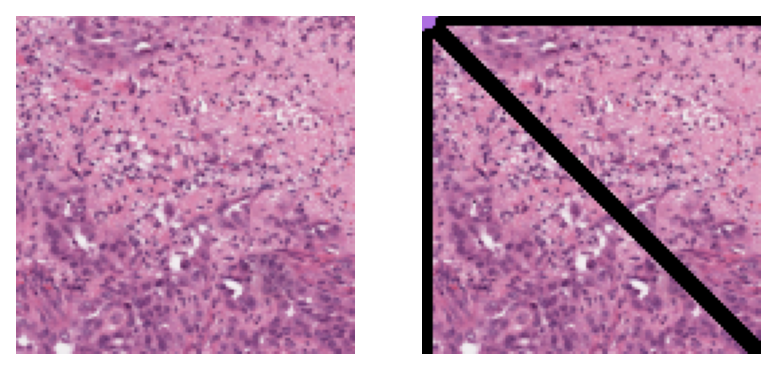

In [11]:
graph_dict = load_json(graph_path)
graph_dict = {k: np.array(v) for k, v in graph_dict.items()}
graph = Data(**graph_dict)

# deriving node colors via projecting n-d features down to 3-d
graph.x = StandardScaler().fit_transform(graph.x)
# .c for node colors
graph.c = PCA(n_components=3).fit_transform(graph.x)[:, [1, 0, 2]]
for channel in range(graph.c.shape[-1]):
    graph.c[:, channel] = (
        1 - equalize_hist(graph.c[:, channel]) ** 2
    )
graph.c = (graph.c * 255).astype(np.uint8)

reader = get_wsireader(wsi_path)
thumb = reader.slide_thumbnail(4.0, 'mpp')
thumb_overlaid = plot_graph(
    thumb.copy(), graph.coords, graph.edge_index.T,
    node_colors=graph.c, node_size=5)
plt.subplot(1, 2, 1)
plt.imshow(thumb)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(thumb_overlaid)
plt.axis('off')
plt.show()

 # The Graph Neural Network

## The Dataset Loader

At the time of writing this, graph datasets were not yet supported by TIAToolbox. We therefore defined here their
loading and IO conversion. The goal of this dataset class is to support loading the input concurrently, and seperately from the running GPU process. The class performs data conversion and other preprocessing if necessary. The `preproc` argument below is available to specify the function that normalizes node features.

In [12]:
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader


class SlideGraphDataset(Dataset):
    """Handling loading graph data from disk.

    Args:
        info_list (list): In case of `train` or `valid` is in `mode`,
            this is expected to be a list of `[uid, label]` . Otherwise,
            it is a list of `uid`. Here, `uid` is used to construct
            `f"{GRAPH_DIR}/{wsi_code}.json"` which is a path points to
            a `.json` file containing the graph structure. On the other
            hand, `label` is the label of the graph. The format within `.json`
            is expected to from `tiatoolbox.tools.graph`.
        mode (str): Denoting which data mode the `info_list` is in.
        preproc (callable): The prerocessing function for each node
            within the graph.

    """

    def __init__(self, info_list, mode="train", preproc=None):
        self.info_list = info_list
        self.mode = mode
        self.preproc = preproc

    def __getitem__(self, idx):
        info = self.info_list[idx]
        if any(v in self.mode for v in ['train', 'valid']):
            wsi_code, label = info
            # torch.Tensor will create 1-d vector not scalar
            label = torch.tensor(label)
        else:
            wsi_code = info

        with open(f"{GRAPH_DIR}/{wsi_code}.json", "r") as fptr:
            graph_dict = json.load(fptr)
        graph_dict = {k: np.array(v) for k, v in graph_dict.items()}

        if self.preproc is not None:
            graph_dict["x"] = self.preproc(graph_dict["x"])

        graph_dict = {k: torch.tensor(v) for k, v in graph_dict.items()}
        graph = Data(**graph_dict)

        if any(v in self.mode for v in ['train', 'valid']):
            return dict(graph=graph, label=label)
        return dict(graph=graph)

    def __len__(self):
        return len(self.info_list)

## Entire Dataset Feature Normalization

We define the feature normalizer, following the approach used for the stain normalizer.
Since this normalization is derived from the entire dataset population, we first load
all the node features from all the graphs within our dataset in order to train the normalizer.

To avoid redundancy, we can skip this training step and use an existing normalizer by
setting `CACHE_PATH` to a valid path. By default, the normalizer is trained and saved
to `SCALER_PATH`. 

In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler

CACHE_PATH = None
SCALER_PATH = f"{ROOT_OUTPUT_DIR}/node_scaler.dat"

In [ ]:
# Uncomment and set these variables to run next cell either
# seperately or with customized parameters
# GRAPH_DIR = 'PATH
# CACHE_PATH = 'PATH'
# SCALER_PATH = 'PATH'
# wsi_names = []

In [13]:
if CACHE_PATH and os.path.exists(CACHE_PATH):
    SCALER_PATH = CACHE_PATH  # assignment for follow up loading
    node_scaler = joblib.load(SCALER_PATH)
else:
    # ! we need a better way of doing this, will have OOM problem
    loader = SlideGraphDataset(wsi_names, mode="infer")
    loader = DataLoader(
        loader,
        num_workers=8,
        batch_size=1,
        shuffle=False,
        drop_last=False
    )
    node_features = [
        v['graph'].x.numpy() for idx, v in enumerate(tqdm(loader))]
    node_features = np.concatenate(node_features, axis=0)
    node_scaler = StandardScaler(copy=False)
    node_scaler.fit(node_features)
    joblib.dump(node_scaler, SCALER_PATH)


# we must define the function after training/loading
def nodes_preproc_func(node_features):
    return node_scaler.transform(node_features)

100%|██████████| 29/29 [00:00<00:00, 67.27it/s]


## GNN Architecture Definition

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm1d, Linear, ReLU
from torch_geometric.nn import (
    EdgeConv,
    GINConv,
    global_add_pool,
    global_max_pool,
    global_mean_pool,
)


class SlideGraphArch(nn.Module):
    def __init__(
        self,
        dim_features,
        dim_target,
        layers=[6, 6],
        pooling="max",
        dropout=0.0,
        conv="GINConv",
        gembed=False,
        **kwargs,
    ):
        super().__init__()
        self.dropout = dropout
        self.embeddings_dim = layers
        self.num_layers = len(self.embeddings_dim)
        self.nns = []
        self.convs = []
        self.linears = []
        self.pooling = {
            "max": global_max_pool,
            "mean": global_mean_pool,
            "add": global_add_pool,
        }[pooling]
        # If True then learn a graph embedding for final classification
        # (classify pooled node features), otherwise pool node decision scores.
        self.gembed = gembed

        conv_dict = {"GINConv": [GINConv, 1], "EdgeConv": [EdgeConv, 2]}
        if conv not in conv_dict:
            raise ValueError(f'Not support `conv="{conv}".')

        def create_linear(in_dims, out_dims):
            return nn.Sequential(
                Linear(in_dims, out_dims), BatchNorm1d(out_dims), ReLU()
            )

        input_emb_dim = dim_features
        out_emb_dim = self.embeddings_dim[0]
        self.first_h = create_linear(input_emb_dim, out_emb_dim)
        self.linears.append(Linear(out_emb_dim, dim_target))

        input_emb_dim = out_emb_dim
        for out_emb_dim in self.embeddings_dim[1:]:
            ConvClass, alpha = conv_dict[conv]
            subnet = create_linear(alpha * input_emb_dim, out_emb_dim)
            # ! this variable should be removed after training integrity checking
            self.nns.append(subnet)  # <--| as it already within ConvClass
            self.convs.append(ConvClass(self.nns[-1], **kwargs))
            self.linears.append(Linear(out_emb_dim, dim_target))
            input_emb_dim = out_emb_dim

        self.nns = torch.nn.ModuleList(self.nns)
        self.convs = torch.nn.ModuleList(self.convs)
        # Has got one more for initial input, what does this mean
        self.linears = torch.nn.ModuleList(self.linears)

        # Auxilary holder for external model, these are saved separately from torch.save
        # as they can be sklearn model etc.
        self.aux_model = {}

    def save(self, path, aux_path):
        state_dict = self.state_dict()
        torch.save(state_dict, path)
        joblib.dump(self.aux_model, aux_path)

    def load(self, path, aux_path):
        state_dict = torch.load(path)
        self.load_state_dict(state_dict)
        self.aux_model = joblib.load(aux_path)

    def forward(self, data):

        feature, edge_index, batch = data.x, data.edge_index, data.batch

        wsi_prediction = 0
        pooling = self.pooling
        node_prediction = 0

        feature = self.first_h(feature)
        for layer in range(self.num_layers):
            if layer == 0:
                node_prediction_sub = self.linears[layer](feature)
                node_prediction += node_prediction_sub
                node_pooled = pooling(node_prediction_sub, batch)
                wsi_prediction_sub = F.dropout(
                    node_pooled, p=self.dropout, training=self.training
                )
                wsi_prediction += wsi_prediction_sub
            else:
                feature = self.convs[layer - 1](feature, edge_index)
                if not self.gembed:
                    node_prediction_sub = self.linears[layer](feature)
                    node_prediction += node_prediction_sub
                    node_pooled = pooling(node_prediction_sub, batch)
                    wsi_prediction_sub = F.dropout(
                        node_pooled, p=self.dropout, training=self.training
                    )
                else:
                    node_pooled = pooling(feature, batch)
                    node_prediction_sub = self.linears[layer](node_pooled)
                    wsi_prediction_sub = F.dropout(
                        node_prediction_sub, p=self.dropout, training=self.training
                    )
                wsi_prediction += wsi_prediction_sub
        return wsi_prediction, node_prediction

    # Run one single step
    @staticmethod
    def train_batch(model, batch_data, on_gpu, optimizer: torch.optim.Optimizer):
        wsi_graphs = batch_data["graph"].to("cuda")
        wsi_labels = batch_data["label"].to("cuda")

        # Data type conversion
        wsi_graphs.x = wsi_graphs.x.type(torch.float32)

        # Not an RNN so does not accumulate
        model.train()
        optimizer.zero_grad()

        wsi_output, _ = model(wsi_graphs)

        # Both are expected to be Nx1
        wsi_labels_ = wsi_labels[:, None]
        wsi_labels_ = wsi_labels_ - wsi_labels_.T
        wsi_output_ = wsi_output - wsi_output.T
        diff = wsi_output_[wsi_labels_ > 0]
        loss = torch.mean(F.relu(1.0 - diff))
        # Backprop and update
        loss.backward()
        optimizer.step()

        #
        loss = loss.detach().cpu().numpy()
        assert not np.isnan(loss)
        wsi_labels = wsi_labels.cpu().numpy()
        return [loss, wsi_output, wsi_labels]

    # Run one inference step
    @staticmethod
    def infer_batch(model, batch_data, on_gpu):
        wsi_graphs = batch_data["graph"].to("cuda")

        # Data type conversion
        wsi_graphs.x = wsi_graphs.x.type(torch.float32)

        # Inference mode
        model.eval()
        # Do not compute the gradient (not training)
        with torch.inference_mode():
            wsi_output, _ = model(wsi_graphs)

        wsi_output = wsi_output.cpu().numpy()
        # Output should be a single tensor or scalar
        if "label" in batch_data:
            wsi_labels = batch_data["label"]
            wsi_labels = wsi_labels.cpu().numpy()
            return wsi_output, wsi_labels
        return [wsi_output]

 To test that our architecture works, at least superficially,
 we perform a brief inference with some random graph data and print
 out the output predictions.

In [ ]:
# Uncomment and set these variables to run next cell either
# seperately or with customized parameters
# GRAPH_DIR = 'PATH'
# NUM_NODE_FEATURES = 4
# wsi_names = []

In [15]:
dummy_ds = SlideGraphDataset(wsi_names, mode="infer")
loader = DataLoader(
    dummy_ds,
    num_workers=0,
    batch_size=8,
    shuffle=False,
)
iterator = iter(loader)
batch_data = iterator.__next__()

# Data type conversion
wsi_graphs = batch_data["graph"]
wsi_graphs.x = wsi_graphs.x.type(torch.float32)

# Define model object
arch_kwargs = dict(
    dim_features=NUM_NODE_FEATURES,
    dim_target=1,
    layers=[16, 16, 8],
    dropout=0.5,
    pooling="mean",
    conv="EdgeConv",
    aggr="max",
)
model = SlideGraphArch(**arch_kwargs)

# Inference section
model.eval()
with torch.inference_mode():
    output, _ = model(wsi_graphs)
    output = output.cpu().numpy()
print(output)

[[-5.274482 ]
 [-5.2743864]
 [-5.2757716]
 [-5.27656  ]
 [-5.272782 ]
 [-5.2744055]
 [-5.274012 ]
 [-5.27648  ]]


Notice that the output values do not lie in the interval [0,1]. Later we will turn the above
values into probabilities using [Platt Scaling](https://en.wikipedia.org/wiki/Platt_scaling).
The scaler will be defined and trained during the training process defined below.
After training is complete, the scaler can be accessed with:

```python
model = SlideGraphArch(**arch_kwargs)
model.aux_model  # will hold the trained Platt Scaler
```

## Batch Sampler

Now that we have ensured that the model can run, let’s take a step back and look at
the model definition again, in preparation for training and inference handling. 

The `infer_batch` is straightforward here: it handles inferencing of the input batch
data and organizes the output content. Likewise, `train_batch` defines training, such as
calculating the loss and so on. The loss defined here is not straightforward or standardized
like cross-entropy. There is a pitfall lurking in the above code that could crash the training.
Consider the lines:

```python
wsi_labels_ = wsi_labels[:, None]
wsi_labels_ = wsi_labels_ - wsi_labels_.T
wsi_output_ = wsi_output - wsi_output.T
diff = wsi_output_[wsi_labels_ > 0]
loss = torch.mean(F.relu(1.0 - diff))
```

Specifically, we need to take care of `diff = wsi_output_[wsi_labels_ > 0]` where
we want to calculate the loss using pairs only positive samples. When a batch contains
no positive samples at all, especially for a skewed dataset, there will no samples to
calculate the loss and we will have `NaN` loss. To resolve this, we define a sampler
specifically for the training process, such that its resulting batch always contains
positive samples.

In [16]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Sampler


class StratifiedSampler(Sampler):
    """Sampling the dataset such that the batch contains stratified samples.

    Args:
        labels (list): List of labels, must be in the same ordering as input
            samples provided to the `SlideGraphDataset` object.
        batch_size (int): Size of the batch.
    Returns:
        List of indices to query from the `SlideGraphDataset` object.

    """

    def __init__(self, labels, batch_size=10):
        self.batch_size = batch_size
        self.num_splits = int(len(labels) / self.batch_size)
        self.labels = labels
        self.num_steps = self.num_splits

    def _sampling(self):
        # do we want to control randomness here
        skf = StratifiedKFold(n_splits=self.num_splits, shuffle=True)
        indices = np.arange(len(self.labels))  # idx holder
        # return array of arrays of indices in each batch
        return [tidx for _, tidx in skf.split(indices, self.labels)]

    def __iter__(self):
        return iter(self._sampling())

    def __len__(self):
        """The length of the sampler.

        This value actually corresponds to the number of steps to query
        sampled batch indices. Thus, to maintain epoch and steps hierarchy,
        this should be equal to the number of expected steps as in usual
        sampling: `steps=dataset_size / batch_size`.

        """
        return self.num_steps

## The Training Loop

Training and running a neural network at the current time involves plugging
several parts together so that they work in tandem. In simplified terms, training
consists of the following steps:

1. Define a network object (`torch.nn.module`) for a particular architecture.
2. Define a loader object to handle loading data concurrently.
3. Define an optimizer(s) and scheduler to update the network weights.
4. Callback functions for several stages (starting of epoch, end of step, etc.)
   to aggregate results, save the models, refresh data, and much more.

For inference, #3 is not necessary.

At the moment, the wiring of these operations is handled mostly in the toolbox via various `engine`.
However, they focus mostly on inference portion. For the SlideGraph case and this
notebook, we also require the `engine` to handle the training portion.
Hence, we define below a very simplified version of what an `engine` usually does
for both `training` and `inference`.

 ### Helper Functions & Classes
 
The function create_pbar simplifies the process of creating a progress bar for tracking the running loop. We also define a class to calculate the exponential moving average (EMA) of the training loss for each step. 

In [17]:
def create_pbar(subset_name: str, num_steps: int):
    """Create a nice progress bar."""
    pbar_format = (
        'Processing: |{bar}| {n_fmt}/{total_fmt}'
        '[{elapsed}<{remaining},{rate_fmt}]'
    )
    pbar = tqdm(
            total=num_steps,
            leave=True,
            bar_format=pbar_format,
            ascii=True)
    if subset_name == 'train':
        pbar_format += (
            'step={postfix[1][step]:0.5f}'
            '|EMA={postfix[1][EMA]:0.5f}'
        )
        # * Changing print char may break the bar so avoid it
        pbar = tqdm(
                total=num_steps,
                leave=True,
                initial=0,
                bar_format=pbar_format,
                ascii=True,
                postfix=['', dict(step=float('NaN'), EMA=float('NaN'))])
    return pbar


class ScalarMovingAverage(object):
    """Class to calculate running average."""

    def __init__(self, alpha=0.95):
        super().__init__()
        self.alpha = alpha
        self.tracking_dict = {}

    def __call__(self, step_output):
        for key, current_value in step_output.items():
            if key in self.tracking_dict:
                old_ema_value = self.tracking_dict[key]
                # Calculate the exponential moving average
                new_ema_value = (
                    old_ema_value * self.alpha + (1.0 - self.alpha) * current_value
                )
                self.tracking_dict[key] = new_ema_value
            else:  # Init for variable which appear for the first time
                new_ema_value = current_value
                self.tracking_dict[key] = new_ema_value

### Defining The Loop

Finally, we define the function to manage the running loop, or the simplified
engine so to speak. The running loop contains of several important events
that require special definition and handling of the dataset, the model, etc.

- **EPOCH_START**: The start of each epoch. Depending on the task, it may be
  necessary to clean up and refresh the data accumulated over the previous epoch
  (such as clearing previous validation results).
- **STEP_START**: The start of each step. The loader is asked for data. The data
  is passed on and training or model inference step is triggered.
- **STEP_STOP**: The end of each step. The loss is computed, console output is logged,
  and the training or inference results are collated.
- **EPOCH_COMPLETE**: The end of each epoch. This often involves saving the model,
  or in our case, starting the training of the Platt Scaler.

Often, each of these events can have their own set of callbacks that will be invoked.
Furthermore, these callbacks may also vary across dataset or running mode (such as
metric calculations, saving mode, etc.). As this is a simplified version,
we include all handling of these within `run_once`. However, in practice, they are
usually factored out into a set of classes and hooks.

The `run_once` function is provided with a dictionary of datasets.
Within this dictionary, `train` is the dataset used for training which
includes the sampler which ensures a positive sample in each batch.
Additionally, `*infer-valid*` and `*infer-train*` are the datasets used for
validation of the model and training of the Platt scaling respectively.
These two datasets do not make use of the sampler which ensures a positive
sample in each batch. Any other dataset in the dictionary which
matches the pattern `*infer*` is assumed to be used for testing.

In [18]:
import logging

from sklearn.metrics import average_precision_score as auprc_scorer
from sklearn.metrics import roc_auc_score as auroc_scorer

from tiatoolbox.tools.scale import PlattScaling


def run_once(
        dataset_dict, num_epochs, save_dir,
        on_gpu=True, pretrained=None,
        loader_kwargs={}, arch_kwargs={}, optim_kwargs={}):
    """Running the inference or training loop once.

    The actual running mode is defined via the code name of the dataset
    within `dataset_dict`. Here, `train` is specifically preserved for
    dataset used for training. `.*infer-valid.*` and `.*infer-train*`
    are preserved for dataset containing the labels. Otherwise,
    the dataset is assumed to be for inference run.

    """
    model = SlideGraphArch(**arch_kwargs)
    if pretrained is not None:
        model.load(*pretrained)
    model = model.to("cuda")
    optimizer = torch.optim.Adam(model.parameters(), **optim_kwargs)

    # Create the graph dataset holder for each subset info then
    # pipe them through torch/torch geometric specific loader
    # for loading in multi-thread.
    loader_dict = {}
    for subset_name, subset in dataset_dict.items():
        _loader_kwargs = copy.deepcopy(loader_kwargs)
        batch_sampler = None
        if subset_name == 'train':
            _loader_kwargs = {}
            batch_sampler = StratifiedSampler(
                labels=[v[1] for v in subset],
                batch_size=loader_kwargs['batch_size']
            )

        ds = SlideGraphDataset(
            subset, mode=subset_name, preproc=nodes_preproc_func)
        loader_dict[subset_name] = DataLoader(
            ds,
            batch_sampler=batch_sampler,
            drop_last=subset_name == "train" and batch_sampler is None,
            shuffle=subset_name == "train" and batch_sampler is None,
            **_loader_kwargs,
        )

    for epoch in range(num_epochs):
        logging.info(f"EPOCH {epoch:03d}")
        for loader_name, loader in loader_dict.items():
            # * EPOCH START
            step_output = []
            ema = ScalarMovingAverage()
            pbar = create_pbar(loader_name, len(loader))
            for step, batch_data in enumerate(loader):
                # * STEP COMPLETE CALLBACKS
                if loader_name == "train":
                    output = model.train_batch(model, batch_data, on_gpu, optimizer)
                    # check the output for agreement
                    ema({"loss": output[0]})
                    pbar.postfix[1]["step"] = output[0]
                    pbar.postfix[1]["EMA"] = ema.tracking_dict['loss']
                else:
                    output = model.infer_batch(model, batch_data, on_gpu)

                    batch_size = batch_data["graph"].num_graphs
                    # Iterate over output head and retrieve
                    # each as N x item, each item may be of
                    # arbitrary dimensions
                    output = [np.split(v, batch_size, axis=0) for v in output]
                    # pairing such that it will be
                    # N batch size x H head list
                    output = list(zip(*output))
                    step_output.extend(output)
                pbar.update()
            pbar.close()

            # * EPOCH COMPLETE

            # Callbacks to process output
            logging_dict = {}
            if loader_name == "train":
                for val_name, val in ema.tracking_dict.items():
                    logging_dict[f"train-EMA-{val_name}"] = val
            elif ("infer" in loader_name and
                    any(v in loader_name for v in ["train", "valid"])):
                # Expand the list of N dataset size x H heads
                # back to a list of H Head each with N samples.
                output = list(zip(*step_output))
                logit, true = output
                logit = np.squeeze(np.array(logit))
                true = np.squeeze(np.array(true))

                if "train" in loader_name:
                    scaler = PlattScaling()
                    scaler.fit(true, logit)
                    model.aux_model['scaler'] = scaler
                scaler = model.aux_model['scaler']
                prob = scaler.transform(logit)

                val = auroc_scorer(true, prob)
                logging_dict[f"{loader_name}-auroc"] = val
                val = auprc_scorer(true, prob)
                logging_dict[f"{loader_name}-auprc"] = val

                logging_dict[f"{loader_name}-raw-logit"] = logit
                logging_dict[f"{loader_name}-raw-true"] = true

            # Callbacks for logging and saving
            for val_name, val in logging_dict.items():
                if 'raw' not in val_name:
                    logging.info(f"{val_name}: {val}")
            if "train" not in loader_dict:
                continue

            # Track the statistics
            new_stats = {}
            if os.path.exists(f"{save_dir}/stats.json"):
                old_stats = load_json(f"{save_dir}/stats.json")
                # Save a backup first
                save_as_json(old_stats, f"{save_dir}/stats.old.json")
                new_stats = copy.deepcopy(old_stats)
                new_stats = {int(k): v for k, v in new_stats.items()}

            old_epoch_stats = {}
            if epoch in new_stats:
                old_epoch_stats = new_stats[epoch]
            old_epoch_stats.update(logging_dict)
            new_stats[epoch] = old_epoch_stats
            save_as_json(new_stats, f"{save_dir}/stats.json")

            # Save the pytorch model
            model.save(
                f"{save_dir}/epoch={epoch:03d}.weights.pth",
                f"{save_dir}/epoch={epoch:03d}.aux.dat"
            )
    return step_output

In [19]:
logging.basicConfig(level=logging.INFO,)


def reset_logging(save_path):
    """Reset logger handler."""
    log_formatter = logging.Formatter(
        '|%(asctime)s.%(msecs)03d| [%(levelname)s] %(message)s',
        datefmt='%Y-%m-%d|%H:%M:%S'
    )
    log = logging.getLogger()     # Root logger
    for hdlr in log.handlers[:]:  # Remove all old handlers
        log.removeHandler(hdlr)
    new_hdlr_list = [
        logging.FileHandler(f"{save_path}/debug.log"),
        logging.StreamHandler()
    ]
    for hdlr in new_hdlr_list:
        hdlr.setFormatter(log_formatter)
        log.addHandler(hdlr)

## Training

With the `engine` above, we can now start our training loop with
a set of parameters:

- `MODEL_DIR`: the location where we save the model weights
  every epoch and associated information. Under it, we have
  - `epoch=[X].weights.pth`: the graph neural network weights after
    the X-th training epoch.
  - `epoch=[X].weights.aux.dat`: the associated sklearn model trained
    for the X-th epoch. In our case, it contains the Platt Scaling.
  - `stats.json`: the file contains accumulated statistic of the entire
    training run for the X-th epoch.
  - `stats.old.json`: the backup file of `stats.json` of the previous epoch.
- `NUM_EPOCHS`: the number of epoch for training.

Additionally, to avoid accidentally over-writing training results, we will
skip the training if the `MODEL_DIR` already exists.

In [ ]:
# Default parameters
NUM_EPOCHS = 100
NUM_NODE_FEATURES = 4
SCALER_PATH = f"{ROOT_OUTPUT_DIR}/node_scaler.dat"
MODEL_DIR = f"{ROOT_OUTPUT_DIR}/model/"

In [ ]:
# Uncomment and set these variables to run next cell either
# seperately or with customized parameters
# NUM_EPOCHS = 100
# NUM_NODE_FEATURES = 4
# GRAPH_DIR = 'PATH'
# SCALER_PATH = 'PATH'
# SPLIT_PATH = 'PATH'
# MODEL_DIR = 'PATH'

In [20]:
splits = joblib.load(SPLIT_PATH)
node_scaler = joblib.load(SCALER_PATH)
loader_kwargs = dict(
    num_workers=8,
    batch_size=16,
)
arch_kwargs = dict(
    dim_features=NUM_NODE_FEATURES,
    dim_target=1,
    layers=[16, 16, 8],
    dropout=0.5,
    pooling="mean",
    conv="EdgeConv",
    aggr="max",
)
optim_kwargs = dict(
    lr=1.0e-3,
    weight_decay=1.0e-4,
)


if not os.path.exists(MODEL_DIR):
    for split_idx, split in enumerate(splits):
        new_split = {
            "train": split['train'],
            "infer-train": split['train'],
            "infer-valid-A": split['valid'],
            "infer-valid-B": split['test'],
        }
        split_save_dir = f"{MODEL_DIR}/{split_idx:02d}/"
        rm_n_mkdir(split_save_dir)
        reset_logging(split_save_dir)
        run_once(
            new_split, NUM_EPOCHS,
            save_dir=split_save_dir,
            arch_kwargs=arch_kwargs,
            loader_kwargs=loader_kwargs,
            optim_kwargs=optim_kwargs)

## Inference

### Model Selections

According to our engine running loop defined above, we will have following
metrics saved for each epoch:

- "infer-train-auroc"
- "infer-train-auprc"
- "infer-valid-auroc"
- "infer-valid-auprc"

With these metrics, we can pick the most promising model weights for inference
on indepedent dataset. We encapsulate this selection within the `select_checkpoints`
function.

> **Note**: For the metrics we defined here (`auroc`, `auprc`), a larger value
> is better. If you want to add your own metrics, remember to change
> the comparison operators within `select_checkpoints` function accordingly.

In [21]:
def select_checkpoints(
        stat_file_path: str,
        top_k: int = 2,
        metric: str = "infer-valid-auprc",
        epoch_range: Tuple[int] = [0, 1000]):
    """Select checkpoints basing on training statistics.

    Args:
        stat_file_path (str): Path pointing to the .json
            which contains the statistics.
        top_k (int): Number of top checkpoints to be selected.
        metric (str): The metric name saved within .json to perform
            selection.
        epoch_range (list): The range of epochs for checking, denoted
            as [start, end] . Epoch x that is `start <= x <= end` is
            kept for further selection.
    Returns:
        paths (list): List of paths or info tuple where each point
            to the correspond check point saving location.
        stats (list): List of corresponding statistics.

    """
    stats_dict = load_json(stat_file_path)
    # k is the epoch counter in this case
    stats_dict = {
        k: v for k, v in stats_dict.items()
        if int(k) >= epoch_range[0] and int(k) <= epoch_range[1]
    }
    stats = [[int(k), v[metric], v] for k, v in stats_dict.items()]
    # sort epoch ranking from largest to smallest
    stats = sorted(stats, key=lambda v: v[1], reverse=True)
    chkpt_stats_list = stats[:top_k]  # select top_k

    model_dir = pathlib.Path(stat_file_path).parent
    epochs = [v[0] for v in chkpt_stats_list]
    paths = [(
        f"{model_dir}/epoch={epoch:03d}.weights.pth",
        f"{model_dir}/epoch={epoch:03d}.aux.dat")
        for epoch in epochs
    ]
    chkpt_stats_list = [[v[0], v[2]] for v in chkpt_stats_list]
    print(paths)
    return paths, chkpt_stats_list

### Bulk Inference & Ensemble Results

In [ ]:
# default parameters
TOP_K = 1
metric_name = 'infer-valid-B-auroc'
PRETRAINED_DIR = f"{ROOT_OUTPUT_DIR}/model/"
SCALER_PATH = f"{ROOT_OUTPUT_DIR}/node_scaler.dat"

In [ ]:
# Uncomment and set these variables to run next cell either
# seperately or with customized parameters
# TOP_K = 1
# NUM_NODE_FEATURES = 4

# PRETRAINED_DIR = 'PATH'
# GRAPH_DIR = 'PATH'
# SCALER_PATH = 'PATH'
# SPLIT_PATH = 'PATH'

# metric_name = 'name'

In [22]:
splits = joblib.load(SPLIT_PATH)
node_scaler = joblib.load(SCALER_PATH)
loader_kwargs = dict(
    num_workers=8,
    batch_size=16,
)
arch_kwargs = dict(
    dim_features=NUM_NODE_FEATURES,
    dim_target=1,
    layers=[16, 16, 8],
    dropout=0.5,
    pooling="mean",
    conv="EdgeConv",
    aggr="max",
)

cum_stats = []
for split_idx, split in enumerate(splits):
    new_split = {
        "infer": [v[0] for v in split["test"]]
    }

    stat_files = recur_find_ext(f'{PRETRAINED_DIR}/{split_idx:02d}/', [".json"])
    stat_files = [v for v in stat_files if ".old.json" not in v]
    assert len(stat_files) == 1
    chkpts, chkpt_stats_list = select_checkpoints(
        stat_files[0], top_k=TOP_K, metric=metric_name)

    # Perform ensembling by averaging probabilities
    # across checkpoint predictions
    cum_results = []
    for chkpt_info in chkpts:
        chkpt_results = run_once(
            new_split,
            num_epochs=1,
            save_dir=None,
            pretrained=chkpt_info,
            arch_kwargs=arch_kwargs,
            loader_kwargs=loader_kwargs,
        )
        # * re-calibrate logit to probabilities
        model = SlideGraphArch(**arch_kwargs)
        model.load(*chkpt_info)
        scaler = model.aux_model['scaler']
        chkpt_results = np.array(chkpt_results)
        chkpt_results = np.squeeze(chkpt_results)
        chkpt_results = scaler.transform(chkpt_results)

        cum_results.append(chkpt_results)
    cum_results = np.array(cum_results)
    cum_results = np.squeeze(cum_results)

    prob = cum_results
    if len(cum_results.shape) == 2:
        prob = np.mean(cum_results, axis=0)

    # * Calculate split statistics
    true = [v[1] for v in split["test"]]
    true = np.array(true)

    cum_stats.append({
        'auroc': auroc_scorer(true, prob),
        'auprc': auprc_scorer(true, prob)
    })

[('/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/00/epoch=073.weights.pth', '/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/00/epoch=073.aux.dat')]


|2021-11-03|18:19:51.309| [INFO] EPOCH 000
Processing: |##########| 10/10[00:00<00:00,15.10it/s]
|2021-11-03|18:19:52.015| [INFO] EPOCH 000
Processing: |          | 0/10[00:00<?,?it/s]

[('/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/01/epoch=086.weights.pth', '/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/01/epoch=086.aux.dat')]


Processing: |##########| 10/10[00:00<00:00,15.42it/s]
|2021-11-03|18:19:52.706| [INFO] EPOCH 000
Processing: |          | 0/10[00:00<?,?it/s]

[('/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/02/epoch=003.weights.pth', '/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/02/epoch=003.aux.dat')]


Processing: |##########| 10/10[00:00<00:00,14.10it/s]
|2021-11-03|18:19:53.472| [INFO] EPOCH 000
Processing: |          | 0/10[00:00<?,?it/s]

[('/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/03/epoch=009.weights.pth', '/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/03/epoch=009.aux.dat')]


Processing: |##########| 10/10[00:00<00:00,15.27it/s]
|2021-11-03|18:19:54.162| [INFO] EPOCH 000
Processing: |          | 0/10[00:00<?,?it/s]

[('/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/04/epoch=085.weights.pth', '/home/dang/storage_1/workspace/tiatoolbox/local/slidegraph/storage/nima/dump/model/04/epoch=085.aux.dat')]


Processing: |##########| 10/10[00:00<00:00,14.80it/s]


 Now we print out the results.

In [23]:
stat_df = pd.DataFrame(cum_stats)
for metric in stat_df.columns:
    vals = stat_df[metric]
    mu = np.mean(vals)
    va = np.std(vals)
    print(f'{metric}: {mu:0.4f}±{va:0.4f}')

auroc: 0.7380±0.0433
auprc: 0.3541±0.0747


### Visualizing Node Activation of Graph Neural Network

Visualizing the activations of each node within the graph is sometimes necessary to either debug or
verify the predictions of the graph neural network. Here, we demonstrate

1. Loading pretrained model and run inference on one single sample graph.
2. Retrieving the node activations and plot it on the original WSI.

By default, notice that node activations are output when running the `mode.forward(input)` (Or
simply `model(input)` in pytorch).

By default, we download the pretrained model as well as samples from the tiatoolbox server to
`DOWNLOAD_DIR`. However, if you want to use your own set of input, you can comment next cell out
and provide your own data accordingly later.

In [6]:
from tiatoolbox.utils.misc import download_data

# ! If you want to run your own set of input, comment this cell and 
# ! check out the next cell
DOWNLOAD_DIR = 'local/dump/'
WSI_PATH = f"{DOWNLOAD_DIR}/sample.svs"
GRAPH_PATH = f"{DOWNLOAD_DIR}/graph.json"
SCALER_PATH = f"{DOWNLOAD_DIR}/node_scaler.dat"
MODEL_WEIGHTS_PATH = f"{DOWNLOAD_DIR}/model.weigths.pth"
MODEL_AUX_PATH = f"{DOWNLOAD_DIR}/model.aux.dat"
rm_n_mkdir(DOWNLOAD_DIR)

# Downloading sample image tile
URL_HOME = "https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition"
download_data(f"{URL_HOME}/TCGA-C8-A278-01Z-00-DX1.188B3FE0-7B20-401A-A6B7-8F1798018162.svs", WSI_PATH)
download_data(f"{URL_HOME}/TCGA-C8-A278-01Z-00-DX1.188B3FE0-7B20-401A-A6B7-8F1798018162.json", GRAPH_PATH)
download_data(f"{URL_HOME}/node_scaler.dat", SCALER_PATH)
download_data(f"{URL_HOME}/model.aux.dat", MODEL_AUX_PATH)
download_data(f"{URL_HOME}/model.weights.pth", MODEL_WEIGHTS_PATH)

Download from https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition/TCGA-C8-A278-01Z-00-DX1.188B3FE0-7B20-401A-A6B7-8F1798018162.svs
Save to local/dump//sample.svs
Download from https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition/TCGA-C8-A278-01Z-00-DX1.188B3FE0-7B20-401A-A6B7-8F1798018162.json
Save to local/dump//graph.json
Download from https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition/node_scaler.dat
Save to local/dump//node_scaler.dat
Download from https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition/model.aux.dat
Save to local/dump//model.aux.dat
Download from https://tiatoolbox.dcs.warwick.ac.uk/models/slide_graph/cell-composition/model.weights.pth
Save to local/dump//model.weigths.pth


In [ ]:
# If you want to run your own set of input, 
# uncomment these lines and then set variables to run next cell
# WSI_PATH = "PATH"
# GRAPH_PATH = "PATH"
# SCALER_PATH = "PATH"
# MODEL_WEIGHTS_PATH = "PATH"
# MODEL_AUX_PATH = "PATH"

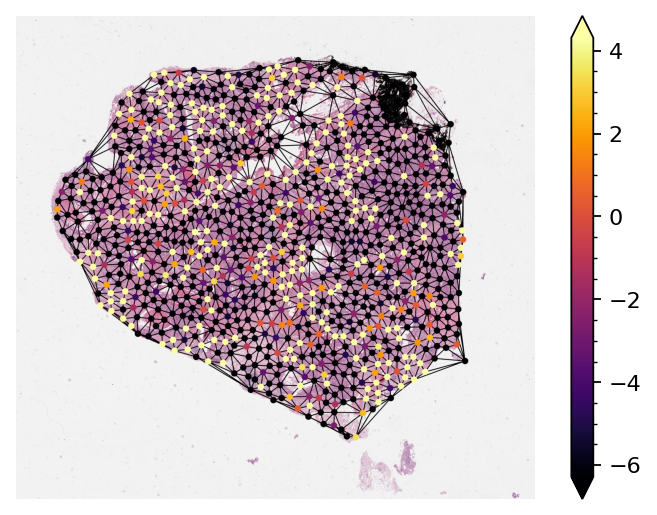

In [6]:
from torch_geometric.data import Batch, Data
import matplotlib.pyplot as plt
from tiatoolbox.wsicore.wsireader import OpenSlideWSIReader
from tiatoolbox.utils.visualization import plot_graph

NODE_SIZE = 25
NUM_NODE_FEATURES = 4
NODE_RESOLUTION = dict(resolution=0.5, units='mpp')
PLOT_RESOLUTION = dict(resolution=4.0, units='mpp')

node_scaler = joblib.load(SCALER_PATH)
loader_kwargs = dict(
    num_workers=8,
    batch_size=16,
)
arch_kwargs = dict(
    dim_features=NUM_NODE_FEATURES,
    dim_target=1,
    layers=[16, 16, 8],
    dropout=0.5,
    pooling="mean",
    conv="EdgeConv",
    aggr="max",
)


with open(GRAPH_PATH, "r") as fptr:
    graph_dict = json.load(fptr)
graph_dict = {k: np.array(v) for k, v in graph_dict.items()}
graph_dict["x"] = node_scaler.transform(graph_dict["x"])
graph_dict = {k: torch.tensor(v) for k, v in graph_dict.items()}
graph = Data(**graph_dict)
batch = Batch.from_data_list([graph])

model = SlideGraphArch(**arch_kwargs)
model.load(MODEL_WEIGHTS_PATH, MODEL_AUX_PATH)
model = model.to('cuda')

# Data type conversion
batch = batch.to('cuda')
batch.x = batch.x.type(torch.float32)
predictions, node_activations = model(batch)
node_activations = node_activations.detach().cpu().numpy()

reader = OpenSlideWSIReader(WSI_PATH)
node_resolution = reader.slide_dimensions(**NODE_RESOLUTION)
plot_resolution = reader.slide_dimensions(**PLOT_RESOLUTION)
fx = np.array(node_resolution) / np.array(plot_resolution)

cmap = plt.get_cmap('inferno')
graph = graph.to('cpu')

node_coordinates = np.array(graph.coords) / fx
node_colors = (
    cmap(np.squeeze(node_activations))
        [..., :3] * 255).astype(np.uint8
)
edges = graph.edge_index.T

thumb = reader.slide_thumbnail(**PLOT_RESOLUTION)
thumb_overlaid = plot_graph(
    thumb.copy(), node_coordinates, edges,
    node_colors=node_colors, node_size=NODE_SIZE
)

ax = plt.subplot(1, 1, 1)
plt.imshow(thumb_overlaid)
plt.axis('off')
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
fig = plt.gcf()
norm = mpl.colors.Normalize(
    vmin=np.min(node_activations),
    vmax=np.max(node_activations)
)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, extend='both')
cbar.minorticks_on()
plt.show()